# Skill assessment - eventwise
***

**Author**: Chus Casado Rodríguez<br>
**Date**: 14-03-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.



**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import sys
import operator
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Configuration

### 1.1 Notification criteria

#### Probability threshold

In [2]:
# probability thresholds
thresholds = np.arange(.05, .96, .05).round(2)
# thresholds = np.round(sigmoid(np.linspace(-10, 10, 50)), 5)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

#### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [3]:
persistence = [(1, 1), (2, 2), (2, 3), (3, 3), (2, 4), (3, 4), (4, 4)]
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

#### Leadtime

Notifications are only sent with a minimum leadtime (h).

In [4]:
min_leadtime = None

### 1.2 Output

In [5]:
name = 'EFAS'

# path where results will be saved
results_path = '../results/'
path_out = f'{results_path}skill/{name}/eventwise/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [6]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

## 2 Data

### 2.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [7]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
folders = os.listdir(f'{results_path}reporting_points/')
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'{results_path}reporting_points/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# remove unnecessary attributes
stations.drop(['rl1.5', 'rl2', 'rl10', 'rl20', 'rl50', 'rl100', 'rl200', 'rl500', 'strahler', 'pfafstetter', 'country'], axis=1, inplace=True)

# convert into integers
stations[['X', 'Y', 'area', 'rl5']] = stations[['X', 'Y', 'area', 'rl5']].astype(int)

no. stations:			900


### 1.2 Forecast: exceedance

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [8]:
# find NetCDF files
path_forecast = '../data/exceedance/forecast/'
files = glob.glob(f'{path_forecast}*.nc')
files = [file for file in files if int(file.split(sep='\\')[-1].split('/')[-1].split('.')[0]) in stations.index]

# load data to a chunked DataArray
fore_exc = xr.open_mfdataset(files, combine='nested', concat_dim='id', chunks={'id': 1}).exceedance
fore_exc['id'] = fore_exc.id.astype(int)

# study period based on the extent of the forecast data
#start, end = [(fore_exc.forecast[i] + fore_exc.leadtime[i]).data for i in [0, -1]]
#start, end = [(date - np.datetime64('1970-01-01T01:00:00Z')) / np.timedelta64(1, 's') for date in [start, end]]
#start, end = [datetime.fromtimestamp(timestamp) for timestamp in [start, end]]

#print(f'Study period\nstart:\t{start}\nend:\t{end}')

##### Reformat data

To be able to compute skill in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the `forecast` is one dimension, and the `leadtime` is another dimension, in a way that there aren't missing values in the matrix. However, this shape is not convenient for comparing against the observed exceedances of the discharge threshold. Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents actual date and time, and another dimension represents leadtime. In this way, a column in the matrix represents the same timestep and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix; therefore, I will remove these parts of the matrix (`trim=True`).

In [9]:
# reshape the DataArray of forecasted exceedance
pred = reshape_DataArray(fore_exc, trim=True, chunks={'id': 1})
del fore_exc

print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(900, 4, 20, 2882)


### 1.3 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In a previous [notebook](2_2_reanalysis_preprocessing.ipynb), the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

no. events:			526
no. stations with events:	322


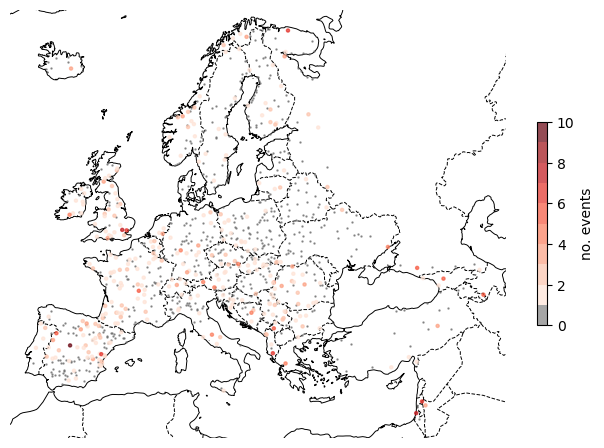

In [43]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[pd.to_datetime(pred.datetime.data), stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
stations['n_events_5'] = n_events_obs.to_pandas()
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))
del rean_onsets

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

# colormap used for the maps
cmap, norm = create_cmap('Reds', np.arange(0, n_events_obs.max(), 1), 'no. events', [0, (.5, .5, .5, .5)])
plot_map_stations(stations.X, stations.Y, n_events_obs.to_pandas(), mask=~mask_stn,
                  cmap=cmap, norm=norm, size=5, figsize=(8, 8),alpha=.7)
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events')
plt.savefig(f'{path_out}/map_observed_events.jpg', dpi=300, bbox_inches='tight');

> ***Figure 1**. Number of observed flood events in the selected reporting points.Small gray dots represent points without observed events.*

The number of events has increased after giving priority to reporting points upstream during the selection process. Out of the 900 selected reporting points, 322 suffered a flood event in the last two years, summing up to a total of 526 observed flood events.

##### Reformat data

I convert the reanalysis data into a `xarray.DataArray`, which will be useful in the following steps.

In [11]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
del rean_exc

# expected probability of an exceedance
obs = obs.astype(int)

print(obs.dims)
print(obs.shape)

('id', 'datetime')
(900, 2882)


The following plot is a graphical explanation of the new format in which forecast exceedance probability is stored. 

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.1 Brier score: a probability assessment

This score is specific for binary classification problems and, since it evaluates only positive cases, it is suited for imbalance datasets. The Brier score is the mean square error between predicted and expeted probabilities:

$$BS = \frac{\sum (p_{pred} - p_{obs})^2}{N}$$ 

As an error mesure, the Brier score is better the closer to 0.

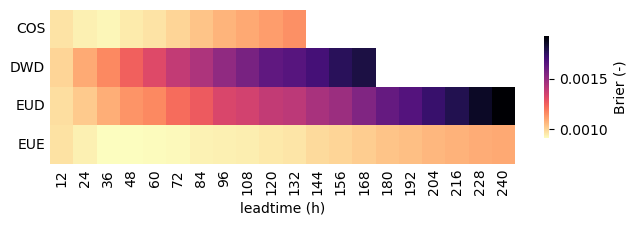

In [12]:
# squared error
se = (obs - pred)**2

# Brier skill of each model and station
brier = se.mean(['id', 'datetime'])

# save the Brier score matrix
brier.to_netcdf(f'{path_out}brier.nc')

# plot Brier score according to model and leadtime
plot_DataArray(brier, xtick_step=1, ytick_step=1, cmap='magma_r', xlabel='leadtime (h)',
        figsize=(7.5, 2), cbar_kws={'label': 'Brier (-)', 'shrink': .666})
plt.savefig(f'{path_out}leadtime_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

# plot Brier score according to model and station
#plot_DataArray(se.mean(['leadtime', 'datetime']).transpose(), yticklabels=se.model.data, ytick_step=1, xticklabels=se.id.data, xtick_step=30,
#        cmap='magma_r', cbar_kws={'label': 'Brier (-)', 'shrink': .666})

> ***Figure 2**. Brier score depending on the meteorological forcing and the leadtime.*

Figure 2 proves that probabilistic forcings have a higher skill (lower Brier score) than the deterministic ones. The skill improves with shorter leadtimes, with the exception of the first day. This matrix of model and leadtime skill can be interesting to weigh models when calculating total probability.

The Brier score has the shortcoming that it's dimensionless (in our case values seem always very low), so it's difficult to compare models. To work around this issue, the **Brier skill score** computes the skill of a model relative to a benchmark model, allowing model comparison:

$$BSS = 1 - \frac{BS_i}{BS_{ref}}$$

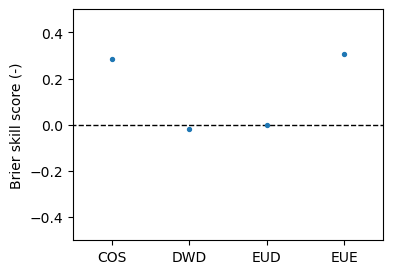

In [13]:
# Brier skill score in terms of NWP model
BSS = 1 - brier.mean('leadtime') / brier.sel(model='EUD').mean('leadtime')

fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(range(0, 4), BSS.data, s=8)
ax.hlines(0, -1, 5, 'k', ls='--', lw=1, zorder=0)
ax.set_xticks(range(0, 4), BSS.model.data)
ax.set(xlim=(-.5, 3.5), ylim=(-.5, .5), ylabel='Brier skill score (-)');

> ***Figure 3**. Brier skill score taking the ECMWF deterministic as a benchmark model.*

The previous plot shows the Brier skill score using as a benchmark the ECMWF deterministic EUD. Positive values represent models better than the reference, whereas negative values represent models worse than the reference. As seen previously, the two probabilistic models have a higher skill than the reference, with ECMWF ensemble as the best forcing. The DWD is the worst of all the forcings. As expected, skill degrades with increasing leadtimes.

We can also look at the geographical distribution of the Brier score according to the meteorological forcing:

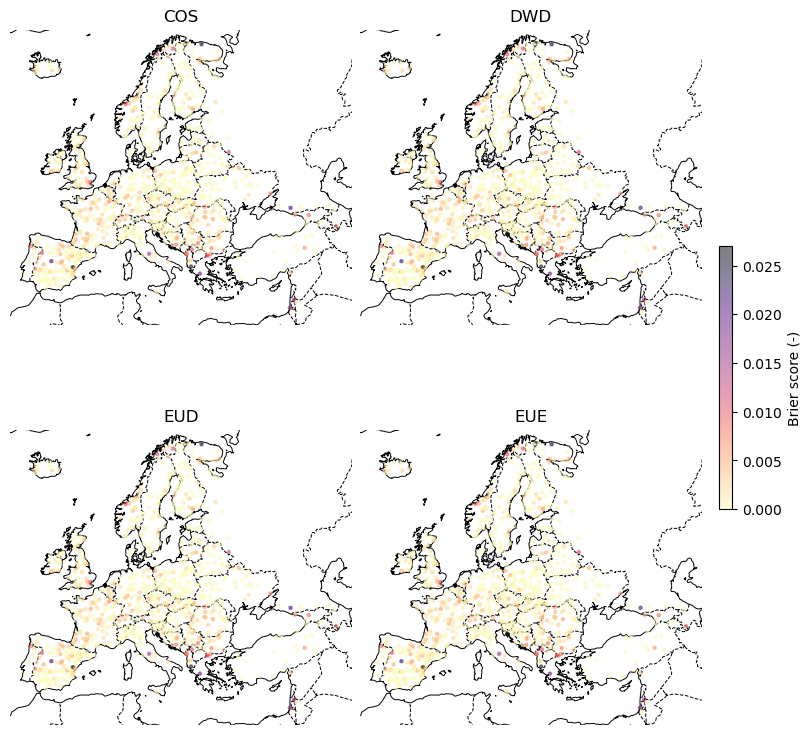

In [14]:
# plot a map of the Brier score 
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), subplot_kw={'projection': proj}, constrained_layout=True)
for ax, model in zip(axes.flatten(), brier.model.data):
    plot_map_stations(stations.X, stations.Y, se.mean(['model', 'leadtime', 'datetime']).to_pandas(), ax=ax,
                      rivers=None, size=5, cmap='magma_r', title=model)#, vmin=0, vmax=.022)
fig.colorbar(plot_map_stations.colorbar, ax=axes[:,1], shrink=.333, label=f'Brier score (-)');

plt.savefig(f'{path_out}eventwise_Brier_all_stations.jpg', bbox_inches='tight', dpi=300)

> ***Figure 4**. Brier score by reporting point and meteorological forcing.*

There are a lot of reporting points with Brier equal to 0, most of them represent stations with neither observed nor predicted events. There are cluster of worse-performing stations in Northern Norway, central and North-East Spain, and the Balcans.

It might be interesting to remove, or look deeper at these reporting points, so they don't affect the overall outcome of the analysis.

In [15]:
# # find stations with poor performance
# BSS_stn = (1 - se.mean(['datetime', 'model', 'leadtime']) / se.mean())
# plt.scatter(range(BSS_stn.shape[0]), BSS_stn, s=5, alpha=.33)
# bad_stations = BSS_stn.loc[BSS_stn < -10].id.data
# stations.loc[bad_stations].sort_values('catchment')

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if observed events where predicted at all, no matter leadtime.

To convert exceedance probability for each meteo forcing into predicted events we need to come up with a total exceedance probability, i.e., combine the probabilities of each meteo forcing into a single probability value. This total probability will later be compared against a probability threshold to discern events. I will test four different approaches:

* `current`:  the current notification criteria. At least a probabilistic and deterministic model must exceed the probability threshold.
* `model_mean`: a simple mean over the 4 forcings.
* `member_weighted`: a mean weighted by the number of members that each meteo forcing contains. In this approach the probabilistic models, specifically that from ECMWF, prevail.
* `brier_weighted`: a mean weighted by the previously calculated Brier score. This is an approach in between the simple mean and the mean weighted by the number of members. Probabilistic forcings will prevail because they proved to be more skillful, but their relative importance is lower than in the previous approach.

#### 3.2.1 Exceedance over probability threshold

In this section I will first compute the total probability using the four approaches previously explained, and then compare the results against the probability thresholds. The outcome will be a boolean dataset of exceedances thresholds named `pred_exc` with 5 dimensions (approach, id, leadtime, datetime, probability).

##### Current

In [16]:
# exceedance according to current criteria
deterministic = (pred.sel(model=['EUD', 'DWD']) >= probabilities).any('model')
probabilistic = (pred.sel(model=['EUE', 'COS']) >= probabilities).any('model')
current = deterministic & probabilistic

##### Model mean

In [17]:
# exceedance according to mean over models
model_mean = pred.mean('model', skipna=True) >= probabilities

##### Member weighted

In [18]:
# DataArray with weights for each model and leadtime
max_leadtime = max(model['leadtimes'] for key, model in models.items())
leadtimes = pd.timedelta_range(timedelta(hours=6), periods=max_leadtime, freq='6h')
weights = np.zeros((len(models), max_leadtime))
for i, (key, model) in enumerate(models.items()):
    leadtime = model['leadtimes']
    member = model['members']
    weights[i,:leadtime] = member
weights = xr.DataArray(weights, dims=['model', 'leadtime'], coords={'model': list(models), 'leadtime': leadtimes})

# exceedance according to the mean over models weighted by the number of members
weights_member = weights.isel(leadtime=slice(None, None, 2))
weights_member['leadtime'] = pred.leadtime
weights_member /= weights_member.sum('model')
member_weighted = pred.weighted(weights_member).mean('model', skipna=True) >= probabilities

##### Brier weighted

To create a weight based on the Brier score I need to invert the values, since lower Brier score values represent better models. Therefore, I compute the inverse of the squared Brier score. To normalize weights (values between 0 and 1) I divide the previous weight matrix by its sum over models.

In [19]:
# exceedance according to the mean over models weighted by the inverse Brier score
brier = se.mean(['id', 'datetime'])
weights_brier = 1 / brier**2
weights_brier /= weights_brier.sum('model')
brier_weighted = pred.weighted(weights_brier.fillna(0)).mean('model', skipna=True) >= probabilities
# exportar weights based on the Brier score
weights_brier.to_netcdf(f'{path_out}weights_brier.nc')

##### Combine approaches

In [20]:
# merge all total probability approaches in a single DataArray
pred_exc = xr.Dataset({
                        'current': current,
                        'model_mean': model_mean,
                        'member_weighted': member_weighted,
                        'brier_weighted': brier_weighted,
                        }).to_array(dim='approach')

pred_exc.dims, pred_exc.shape

# del pred

(('approach', 'id', 'leadtime', 'datetime', 'probability'),
 (4, 900, 20, 2882, 19))

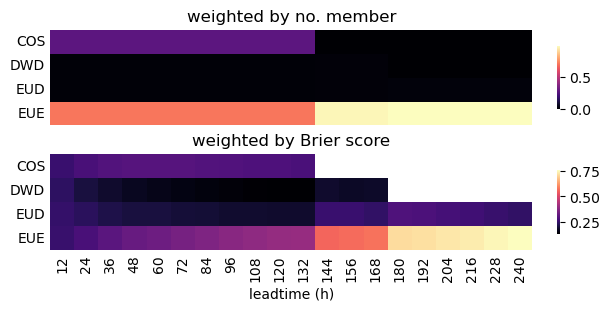

In [21]:
# heatmap of weights
fig, axes = plt.subplots(nrows=2, figsize=(6, 3), constrained_layout=True, sharex=True, sharey=True)
Weights = xr.Dataset({'no. member': weights_member, 'Brier score': weights_brier})
for i, (ax, (var, da)) in enumerate(zip(axes, Weights.items())):
    htm = plot_DataArray(da, vmin=0, vmax=1, ax=ax, ytick_step=1, xtick_step=1, title=f'weighted by {var}', cbar_kws={'shrink': .66})
    if i == len(axes) - 1:
        ax.set_xlabel('leadtime (h)')

> ***Figure 5**. Weighting matrixes used to compute total probability according to the number of members of the meteorological forcing (top) or the skill measured in terms of Brier score (bottom).*

The previous plot shows the weighting factors for the mean weighted by the number of members of each model (top), and the mean weighted by the performace of the model measured in terms of Brier score (bottom). When taking into account the number of members, obviously COSMO-LEPS and EUE get the vast majority of the weight, rendering no importance to any of the deterministic models. Between the two probabilistic models, EUE prevails over COSMO-LEPS, even though we've seen that their performance is comparable. However, when weighting according to performance, COSMO-LEPS and EUE get a very similar value during the leadtime span for which COSMO-LEPS is available. The probabilistic models have lower weights, but not as insignificat as when weighting by the number of members. In this sense, this last weighting method is a halfway point between the simple model mean and the mean weighted by the number of members.

#### 3.2.2 Compute skill

The computation of skill consists on three steps:

1. Define events according to the notification criteria (persistence and minimum leadtime). The probability threshold was already taken into account when computing the exceedance over threshold in the previous section.

2. Compute hits, misses and false alarms by comparing observation and predictions. At this step a window function is applied to count as hits predictions that have minor time lags compared with the observation.

3. Compute skill metrics (recall, precicion and f1).

##### Define events

In [22]:
# compute predicted events 
pred_events = {label: compute_events(pred_exc, persistence=pers, min_leadtime=min_leadtime) for label, pers in persistence.items()}
pred_events = xr.Dataset(pred_events).to_array(dim='persistence').chunk({'id': 1})

##### Hits, misses and false alarms

In the computation of hits, misses and false alarms I have applied a centered window function of width 5, which allows for a time lag between prediction and observations of 2 timestep (12 h) both before or after the observed events. 

I have also tried an asymmetrical (right-sided) window function of width 3 that allows only for 2-timestep lag (12 h) when the forecast predicts the event sooner than it actually happened. In the posterior skill analysis this approach proved slightly poorer (maximum f1-score of 0.40 instead of 0.51) than when applying the centered window.

Personally, I think that applying a centered window is correct. Since one of the notification criteria states that notifications are only raised for leadtimes larger than 48 h, the fact that the prediction is 12 h delayed will still give, in the worst case, 36 h of notice.

In [23]:
# # several window functions
# windows = [(True, 3), (True, 5), (False, 3)]
# labels = [f'sym_{w[1]}' if w[0] else f'asym_{w[1]}' for w in windows]
# windows = {label: window for label, window in zip(labels, windows)}

In [24]:
# check if the hit NetCDF files already exist and load them
hit_files = [file for file in glob.glob(f'{path_out}*.nc') if file[-5:-3] in ['TP', 'FN', 'FP']]
if len(hit_files) == 3:
    print('Loading previously computed hit files')
    hits = xr.open_mfdataset(hit_files).compute()
    hits.close()
else:
    print('Computing hits')
    # otherwise, compute hits, misses and false alarms
    hits = compute_hits(obs, pred_events, center=True, w=5).compute()
    # export results as NetCDF
    for label, da in hits.items():
        file_out = f'{path_out}{label}.nc'
        print(f'Exporting file {file_out}')
        da.to_netcdf(file_out)

Computing hits
Exporting file ../results/skill/EFAS/eventwise/TP.nc
Exporting file ../results/skill/EFAS/eventwise/FN.nc
Exporting file ../results/skill/EFAS/eventwise/FP.nc


##### Compute skill

In [25]:
# compute skill metrics
skill = xr.Dataset({'recall': hits.TP.sum('id') / (hits.TP.sum('id') + hits.FN.sum('id')),
                    'precision': hits.TP.sum('id') / (hits.TP.sum('id') + hits.FP.sum('id')),
                    'f1': 2 * hits.TP.sum('id') / (2 * hits.TP.sum('id') + hits.FP.sum('id') + hits.FN.sum('id'))})

#### 3.2.3 Analyse overall skill

##### Hits, misses and false alarms

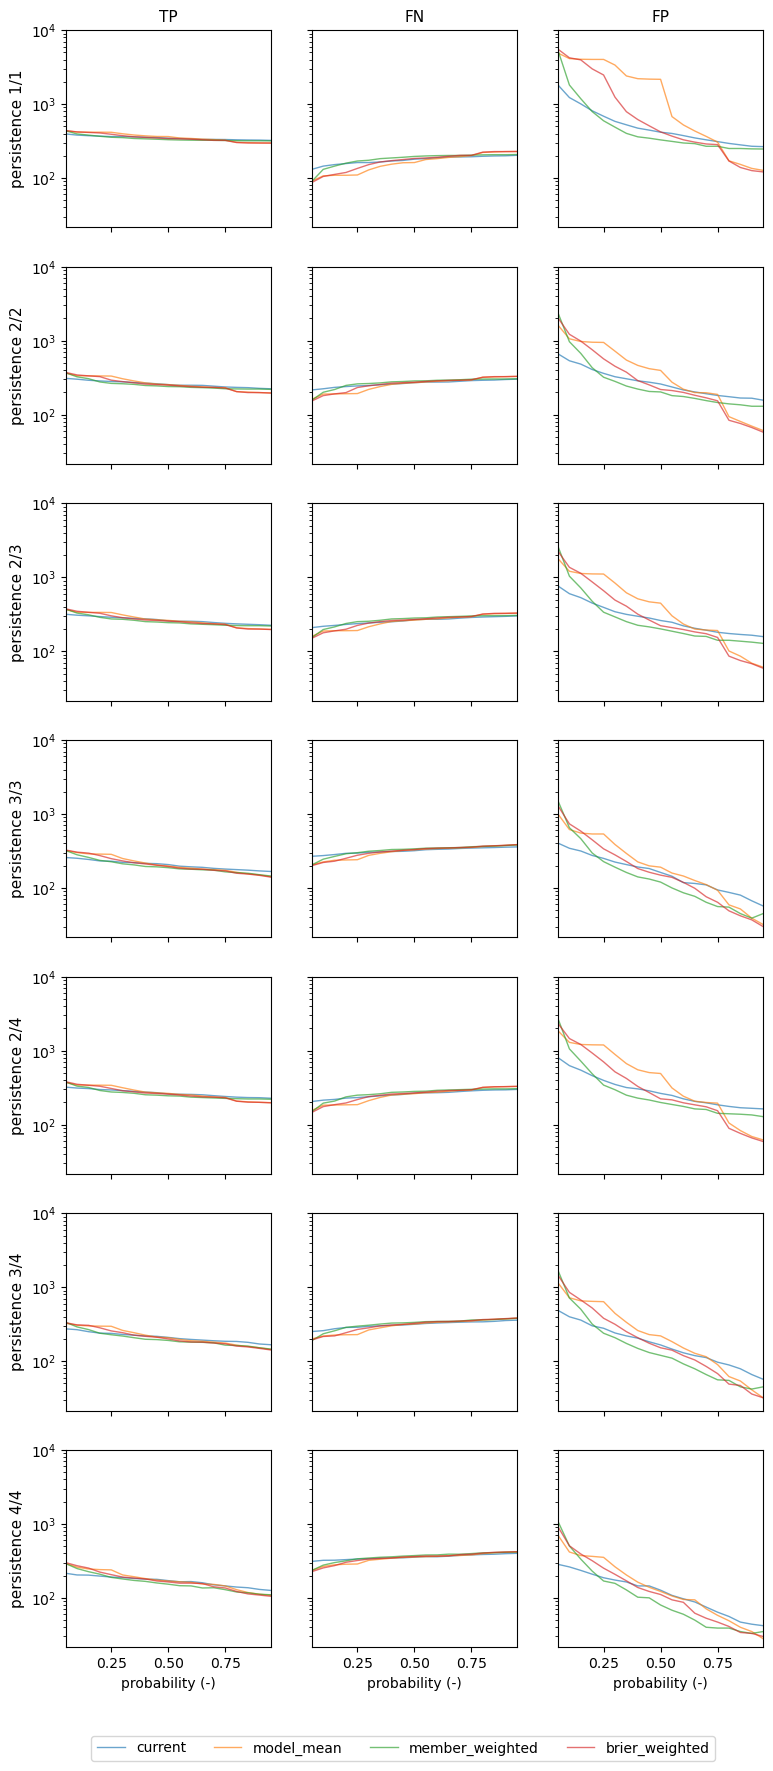

In [26]:
# plot hits, misses and false alarms
lineplot_skill(hits.sum('id'), save=f'{path_out}eventwise_hits_(all_stations).jpg')

> ***Figure 6**. Counts of true positives (TP), false negatives (FN) and false positives (FP) depending on the probability threshold. Every row in the graph represents a different peristence criterion. The 4 lines in each plot represent the 4 methods used to combine the 4 meteorological forcings into total probability. The Y axis (counts) is in logarithmic scale because the different order of magnitude of FP compared with TP and FN.*

Insights of the previous figure:

**True positives (TP)**

The number of true positives has a general negative trend with higher probability thresholds. As this threshold increases, we predict less events and, hence, we hit less observed events. This trend is shown for every persistence criterion and approach method. Therefore, the smaller the probability threshold, the higher the TP.

The persistence criterion affects the number of true positives. Stricter criteria generate less predicted events and, hence, less TP.

The spread between approach method is negiglible and constant throughout different persistences.

The maximum value of TP, obtained by the most relaxed probability and persistence criteria, is around 400. This value is approximately 20 % lower than the number of observed events (526), which means that no matter the notification criteria, we can't predict all the events.

**False negatives (FN)**

The analysis of the false negatives is similar to that of true positives, but with an opposite trend regarding the probability criterion. Lower porbability thresholds predict a larger number of events, so fewer observed events will be missed. As we will see later, the effect is the opposite when looking at the false positives; however, the slope of the relation probability-FN is much lower than that of the relation probability-FP. In general, this relation is fairly linear, except for very low probability values.

The persistence criterion has a minor effect on the false negatives, with larger values for stricter persistence values.

**False positives (FP)**

FP is the most sensitive variable, both regarding the probability and the persistence criteria. 

Regarding the probability threshold, the slope of the FP plots is much larger than FP or FN. As we raise the probability threshold, we are more certain that an event will happen when we forecast it, and the number of false positives decreases. The relation between the probability threshold and the number of false positives is fairly linear, except for the approach *member_weighted*. Therefore, the optimal probability threshold will be always very high (if not the maximum) to limit the number of false positives.

Another approach to limit the number of false positives is to add the persistence criterion. When doing away with persistence (top-right plot), FP ranges from a few thousands to a few hundreds depending on the probability threshold. As we apply more restrictive persistence (going down the graph), the amount of FP is reduced drastically to a range between less than a thousand and a few dozens for the most restrictive persistence (bottom-right plot).

FP is also the variable that shows a larger spread among approach methods, even though all the methods show a similar trend. The stricter the persistence criterion, the narrower the spread.
<br>
<br>
> <font color='royalblue'>The most important idea to extract from the previous figure is that **the most sensitive variable is the number of false positives** and that the optimal notification criteria will be the one that minimizes this value without compromising excesively the true positives and false negatives.</font>

##### Skill: recall, precision and f1

Best criteria:
--------------

probability:	0.95
approach:	brier_weighted
persistence:	1/1

    recall = 0.565
 precision = 0.711
        f1 = 0.629


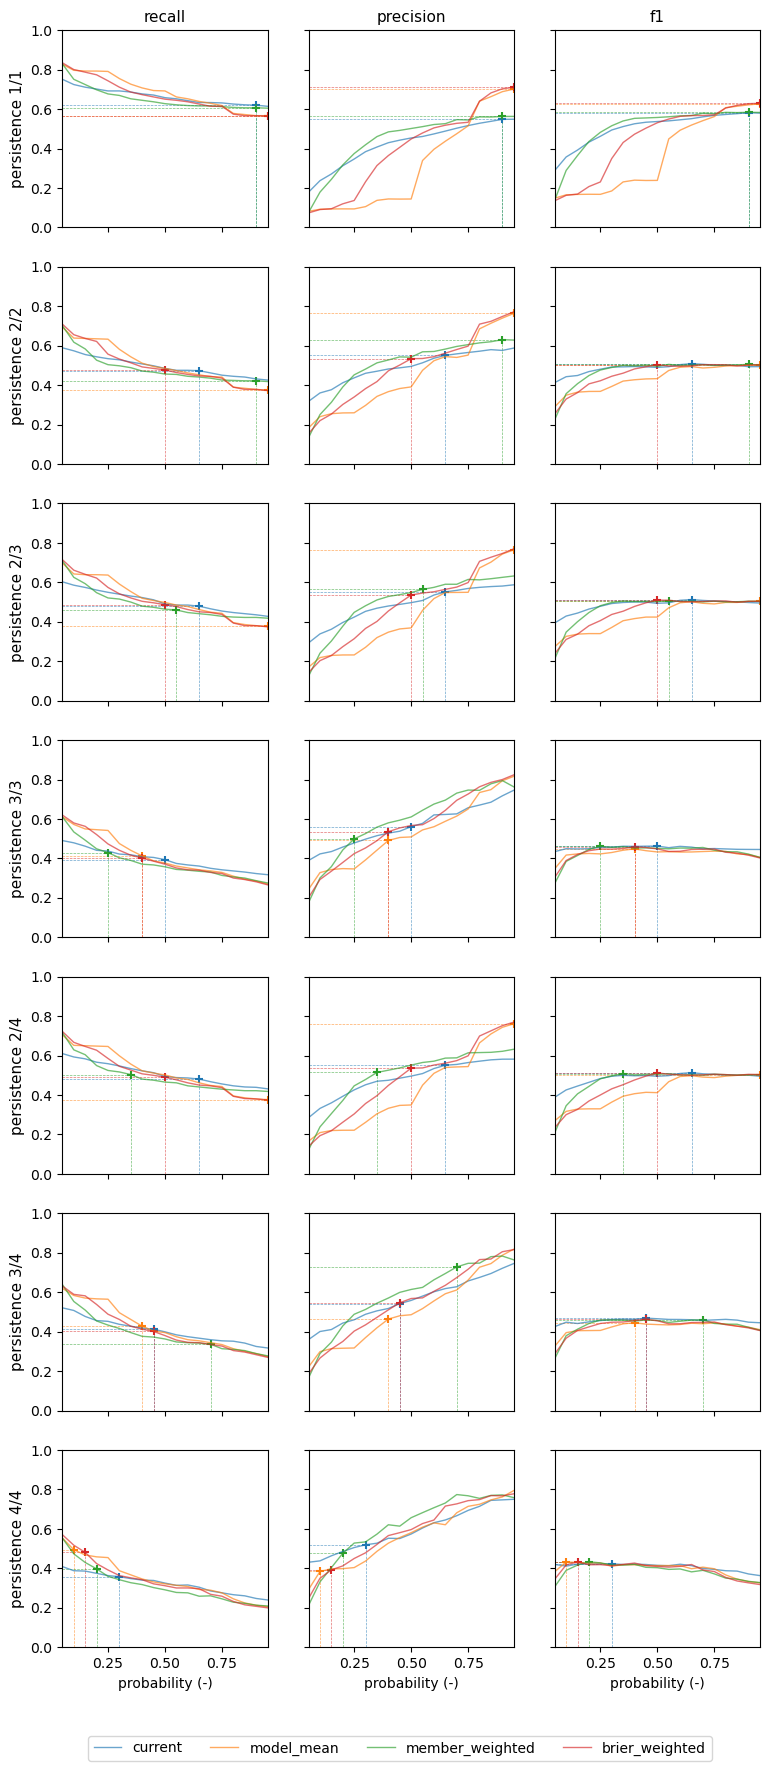

In [27]:
# plot skill metrics
lineplot_skill(skill, bestvar='f1', yscale='linear', round=1, save=f'{path_out}skill_eventwise_(all_stations).jpg')

print('Best criteria:')
print('--------------\n')

best_criteria = skill['f1'].argmax(['approach', 'probability', 'persistence'])

for dim in skill.dims:
    print('{0}:\t{1}'.format(dim, skill.isel(best_criteria)[dim].data))

print()
for var in list(skill):
    print('{0:>10} = {1:.3f}'.format(var, skill[var].isel(best_criteria).data))

> ***Figure 7**. EFAS skill predicting flood events in terms of $recall$, $precision$ and $f1$. Every plot shows the variability of the skill metric depending on the probability threshold for the 4 methods used to compute total probability. Every row represents a different persistence criterion, with stricter persistence as we go down the figure. Crosses represent the probability that optimizes $f1$ for that specific persistence and approach method; the same probability is used for the $recall$, $precision$ and $f1$ plots.*

**Recall**

As expected, both $recall$ and $precision$ show monotic and opposite trends along the probability axes. $Recall$ decreases with higher probability thresholds, since the number of true positives is maximized and the number of false negatives minimized (see Figure X). This trend is mostly linear, but for the lowest probability thresholds, and similar over approach methods and persistence criteria. 

**Precision**

On the contrary, $precision$ increases with higher probability, which means that the reduction of false positives prevails over a smaller reduction in false positives (see Figure X). The behabiour of presicion is more erratic both in terms of persistence and approach method, so we can't specify a general trend. The best example of this erratic behaviour is the plot for persistence 1 (no persistence), where every model behaves differently; some seem to have an asintotic behaviour (_current_, *member_weighted*), whereas the others are insentive for lower probabilities and then increase dramatically.

**f1**

Before getting into details, a reminder that $f1$ is the harmonic mean of $recall$ and $precision$, being a proper metric to combine the other two metrics in unbalanced problems such as this one.

Luckily, $f1$ does not have a monotonic behaviour, which would cause that the optimal probability threshold would be either very low or very large. Instead, we can see two different behaviours depending on the persistence criterion. On the one hand, the more relax persistence criteria (1/1, 2/2 and 2/4) show an asymptotic behaviour, i.e., from a certain probability onwards, the f1 score is basically constant. On the other hand, the stricter persistence critera (3/3, 3/4 and 4/4) show a wide plateau over which f1 is constant, but the skill worsens for very large probability thresholds. Interestingly, the f1 score of this plateau/asymptote is the same (or almost the same) for every approach method; the difference between methods is the probability threshold at which the plateau is reached and at which f1 peaks. Therefore, the method used to compute the total probability is not determining the overall skill.

Persistence affects the results in two ways. First, it defines the f1 score of the plateau/asymptote. The highest f1 score (0.46) is reached for persistence 2/4, but other persistence criteria have close results. However, very strict criteria (3/3, 3/4 and 4/4) reduce the skill to values closer to 0.40. Second, persistence affects the optimal probability threshold. There seems to be a trade-off between persistence and probability, in a sense that relaxed persistence requires higher probability thresholds, whereas strict persistence allows for smaller probability thresholds. The highest f1 score (0.46) is reached for a probability threshold of 50%.

> <font color='royalblue'>From these results we can extract that **$f1$ can be optimised in terms of persistence and probability threshold**. The approach used to compute total probability, however, does not affect the maximum $f1$ score. There's a **trade-off between persistence and probability**, since together they must constrain the amount of false positives, hence, improve $precision$ and $f1$. **The highest performing combination of criteria is that with a probability threshold of 50%, a persistence of 2 out of 4 forecast, and for which total probability was computed using the Brier score as a weighing factor**.</font>

#### 3.2.4 Anaylse skill by reporting points

##### Hits, misses and false alarms

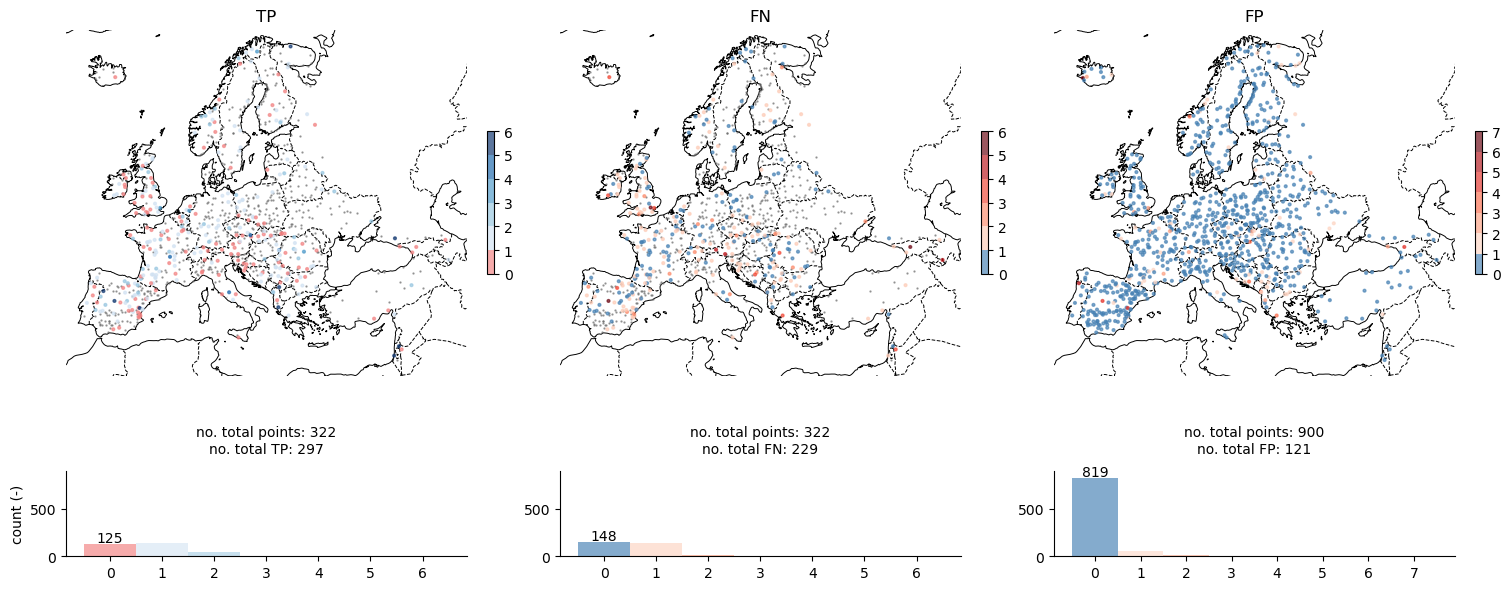

In [32]:
# extract the hits, misses and false alarm for each station based on the best criteria
hits_stn = hits.isel(best_criteria)
for var, da in hits_stn.items():
    # convert xr.DataArray to pd.Series
    stations[var] = da.to_pandas()

map_hits(stations, cols=['TP', 'FN', 'FP'], mask=mask_stn,
         save=f'{path_out}hits_eventwise_maps_reporting_points.jpg')

> ***Figure 8**. Maps of hits, misses and false alarms for each reporting point with the best performing criteria. The colour scale changes depending on the variable with the rational that red (darker red) means worse values, whereas blue (darker blue) better values. In the case of hits (TP) and misses (FN) a mask has been applied to remove reporting points with no observed events (gray points), since none of these variables make sense if there are no observations to predict or miss.*

The figure above shows the number of hits (TP), misses (FN) and false alarms (FP) by reporting point for the best-performing criteria. Red colours represent bad behaviour, whereas blue colours good behabiour.

**Hits (TP)**

The reporting points shown in this plot are only those with at least one observed event (the rest are "masked" and shown with gray points). The number of reporting points with at least one observed event is 322; from those, the model didn't predict any event in more than a half (178). If we look at the total amount of events, less than a half of the observed events were correctly predicted (213/526). There doesn't seem to be a clear geographic pattern neither for the bad nor the good performing points.

**Misses (FN)**

As in the previous case, this plot only shows points with observed events (322). Out of these reporting points, approximately a third had no misses. In total, more than half of the events were missed (313 out of 526).

**False alarms (FP)**

The best criteria would raise 188 false alarms in 125 reporting points. Some points would report as many as 7 false alarm, which may be an indicator of a specific problem in the hydrological simulation of those points.

In [33]:
# station with higher amount of misses
stations.loc[stations.FN > 4].sort_values('FN', ascending=False)

name        X        Y  area subcatchment  \
station_id                                                                 
2996                      Burguillo  3097500  2042500  1075     Alberche   
1572        Feildes Weir Ultrasonic  3632500  3227500  1175          Lee   
2701                     NAMOKHVANI  6927500  2727500  3550        Rioni   

               river catchment  rl5  n_events_5  TP  FN  FP  
station_id                                                   
2996        Alberche     Tagus   79          11   5   6   4  
1572             Lee    Thames   51           7   1   6   0  
2701           RIONI     Rioni  331           5   0   5   4

In [34]:
# stations with a higher amount of false alarms
stations.loc[stations.FP > 2].sort_values('FP', ascending=False)

name        X        Y  area subcatchment  \
station_id                                                        
2191               SELFOSS  2847500  4872500  1425      Oelfusa   
1454        Ponte Da Barca  2797500  2267500  2100         Lima   
4324                Arenos  3417500  1952500  1450      Mijares   
2701            NAMOKHVANI  6927500  2727500  3550        Rioni   
2996             Burguillo  3097500  2042500  1075     Alberche   
2149              AVLAKION  5307500  1857500  1550     Akheloos   
4439               Kamenín  4967500  2792500  5125         Hron   
4015               Shkoder  5107500  2157500  5275       Bojana   
1746                Mostar  4957500  2287500  3325      Neretva   
2907         Rauma v-Venge  4202500  4382500  1250        Rauma   

                       river catchment  rl5  n_events_5  TP  FN  FP  
station_id                                                           
2191                 Oelfusa   Oelfusa  217           0   0   0   7  
1454                    Lima      Lima  303           1   1   0   5  
4324                 Mijares   Mijares    4           6   5   1   4  
2701                   RIONI     Rioni  331           5   0   5   4  
2996                Alberche     Tagus   79          11   5   6   4  
2149        Acheloos Potamos  Akheloos  244           4   1   3   3  
4439                    Hron    Danube  343           0   0   0   3  
4015                  Bojana      Drin  820           2   1   1   3  
1746                 Neretva   Neretva  430           1   1   0   3  
2907                   Rauma     Rauma  186           2   2   0   3

##### Skill: recall, precision and f1

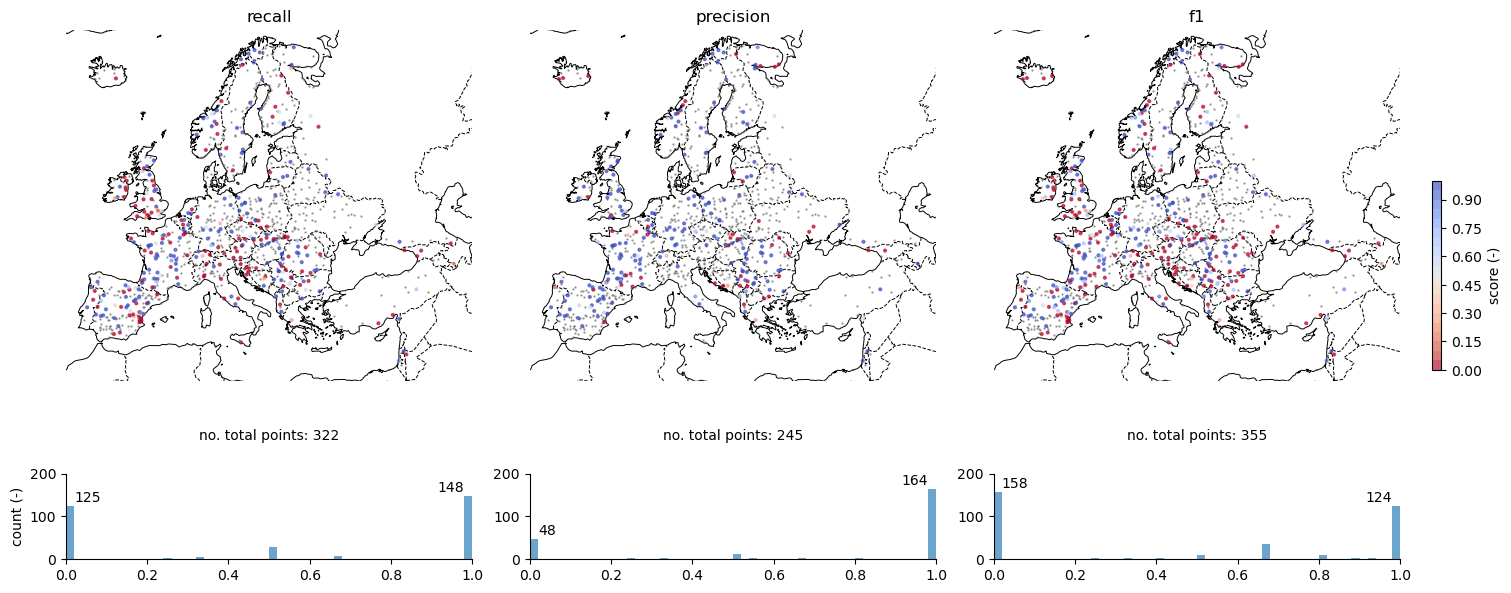

In [42]:
# compute metrics
stations['recall'] = stations.TP / (stations.TP + stations.FN)
stations['precision'] = stations.TP / (stations.TP + stations.FP)
stations['f1'] = 2 * stations.TP / (2 * stations.TP + stations.FN + stations.FP)

cmap_f1, norm_f1 = create_cmap('coolwarm_r', bounds=np.arange(.0, 1.01, .05))
map_skill(stations, cols=['recall', 'precision', 'f1'], bins=50, cmap=cmap_f1, norm=norm_f1,
          save=f'{path_out}skill_eventwise_maps_reporting_points.jpg')

> ***Figure 9**. EFAS skill (in terms of recall, precision and f1) disaggregated by reporting points. Gray dots represent reporting points for which the metric cannot be calculated (division 0 by 0); these points vary from one metric to another. The texts at the bottom show the number of zeros or ones in the metric out of the number of reporting points for which it was possible to compute the metric.*

For the majority of reporting points the metrics can't be computed. The numberr of reported points is 900, whereas the metric with more values (f1) could only be computed for 388 stations. This means that when analysing the results by reporting points, almost two third of them are discarded.

The histograms at the bottom show the distribution of the metric values. In all three metrics the results are polarised, with most of the points having either a metric value of 0 or 1.

**Recall**

Recall could be computed for the 322 stations that have observed events. Out of those, in more than a half (178) none of the observed events were detected (recall = 0). On the contrary, in a third of the stations all the events were detected (recall = 1). 

**Precision**

Precistion could be computed in less reporting points than recall (234 out of 900). Approximately in half of the points (109) all the predicted events were correct (precision = 1), whereas in another half (90) none of the predicted events were right (precision = 0)

**f1**

F1 could be computed in more points than the previous two metrics (388 out of 900). However, it's the metric with worse results. Approximately two thirds (244 out of 388) of the points show now skill (f1 = 0), and only a fifth (81 out of 388) a perfect skill (f1 = 1).


##### Precision-recall curve

In [ ]:
skill_persistence = skill.sel(persistence='2/4')

In [ ]:
lab = 'model_mean'

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

for label in skill.approach.data:
    ax.plot(skill.sel(persistence='2/4', approach=label).recall.data,
            skill.sel(persistence='2/4', approach=label).precision.data,
            label=label)
ax.set(xlim=(0, 1), ylim=(0, 1), xlabel='recall', ylabel='precision', title='precision-recall curve') 
ax.set_aspect('equal')
ax.legend(loc=0);

***

In [ ]:
pred_events